In [2]:

import cv2
import json
from src.lib.utils.pnp.cuboid_pnp_shell import pnp_shell
import matplotlib.pyplot as plt
import numpy as np
from src.lib.opts import opts
from itertools import permutations
import copy
import math


In [6]:
opt = opts()
opt.nms = True
opt.obj_scale = True
opt.c = "cereal_box" # category

print(opt.nms, opt.obj_scale )

True True


In [4]:
# Take GT as imput:
gt1= {"image_name": "IMG_0594.JPG", "points": [[2810, 1365], [2522, 945], [1992, 814], [2519, 2040], [1980, 2043], [3806, 551], [3272, 295], [3827, 2049], [3284, 2056]], "size": [305, 230,130 ]}
gt2= {"image_name": "IMG_0588.JPG", "points": [[2759, 1139], [2424, 527], [2225, 270], [2461, 1656], [2301, 2048], [3072, 515], [3269, 249], [3070, 1646], [3249, 2033]], "size": [305, 230, 130]}
gt3= {"image_name": "IMG_1129.JPG", "points": [[2717, 2060], [1175, 1503], [2061, 1320], [1663, 3306], [2596, 3629], [2786, 1167], [3619, 994], [3037, 2421], [3863, 2473]], "size": [395, 300, 208]}
ceareal_gt={"image_name":"00000.png","projected_cuboid": [
                [
                    298,
                    427
                ],
                [
                    212,
                    532
                ],
                [
                    170,
                    643
                ],
                [
                    115,
                    143
                ],
                [
                    14,
                    203
                ],
                [
                    453,
                    548
                ],
                [
                    457,
                    674
                ],
                [
                    480,
                    120
                ],
                [
                    499,
                    182
                ]
            ],"scale": [
                0.17000000178813934,
                0.27000001072883606,
                0.09000000357627869
            ]}

In [7]:
# first test with GT cereal:
size = ceareal_gt["scale"]
points=ceareal_gt["projected_cuboid"]
img=plt.imread("data/outf_all/cereal/cereal_box_batch-1_0/00000.png")
plt.imshow(img)
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'data/outf_all/cereal/cereal_box_batch-1_0/00000.png'

In [27]:
camera_cereal=np.array([[663.0287679036459, 0, 300.2775065104167], [0, 663.0287679036459, 395.00066121419275], [0, 0, 1]])
camera_ford=np.array([[3648, 0, 2736], [0, 3648, 1824], [0, 0, 1]], dtype=np.float32)

In [28]:
bbox= {'kps': points, "obj_scale": size}
meta={"width": img.shape[1],"height": img.shape[0], "camera_matrix":camera_cereal }

In [29]:
projected_points, point_3d_cam, scale, points_ori, bbox=pnp_shell(opt, meta, bbox, points, size, OPENCV_RETURN=False)

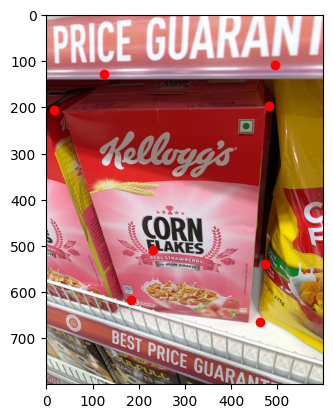

In [30]:
# print("projected_points", projected_points)
# print(point_3d_cam)
# print(scale)
# print(points_ori) # empty
plt.imshow(img)
for p in bbox["projected_cuboid"]:
     plt.plot(p[0],p[1], 'ro')
plt.show()

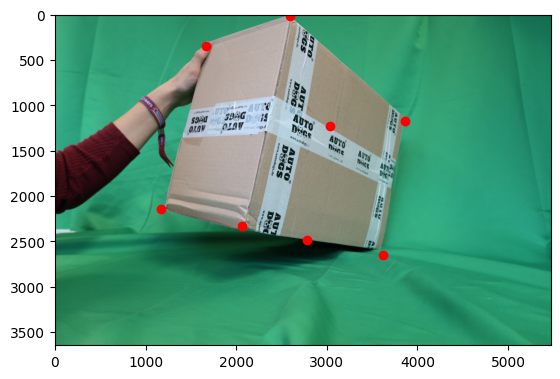

In [31]:
# first test with GT me:
img=plt.imread("data/outf_all/validation/"+gt3["image_name"])
plt.imshow(img)


h=img.shape[0]
size=gt3["size"]
points=gt3["points"]
# invert points: 
for i, p in enumerate(points):
    points[i]=[p[0], h-p[1]]


for p in points[1:]:
    plt.plot(p[0],p[1], 'ro')
plt.show()
points=points[1:]


In [32]:
def dist(pnp, anno):
    distance=0
    for a, p in zip(pnp, anno):
        distance+=math.dist(a, p)
    return distance

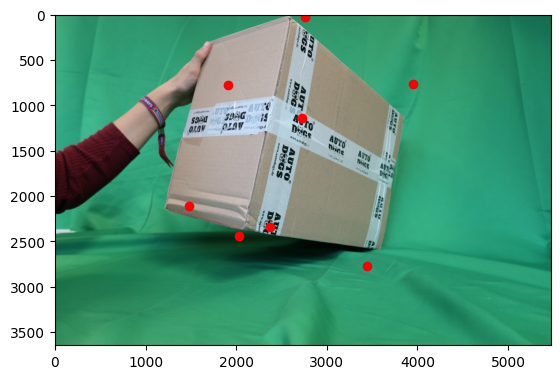

In [36]:
bbox= {'kps': points, "obj_scale": size}
meta={"width": img.shape[1],"height": img.shape[0], "camera_matrix":camera_ford }
projected_points, point_3d_cam, scale, points_ori, bbox=pnp_shell(opt, meta, bbox, points, size, OPENCV_RETURN=False)
for p in bbox["projected_cuboid"]:
    plt.plot(p[0], p[1], 'ro')
plt.imshow(img)
plt.show()

In [33]:

correct_dim=0
big_value=10000000
big_size_list=(list(permutations(size)))
for size in big_size_list:
    bbox= {'kps': points, "obj_scale": size}
    meta={"width": img.shape[1],"height": img.shape[0], "camera_matrix":camera_ford }
    projected_points, point_3d_cam, scale, points_ori, bbox=pnp_shell(opt, meta, bbox, points, size, OPENCV_RETURN=False)
    d=dist(bbox["projected_cuboid"], points)
    if d < big_value:
        big_value=d
        correct_dim=size

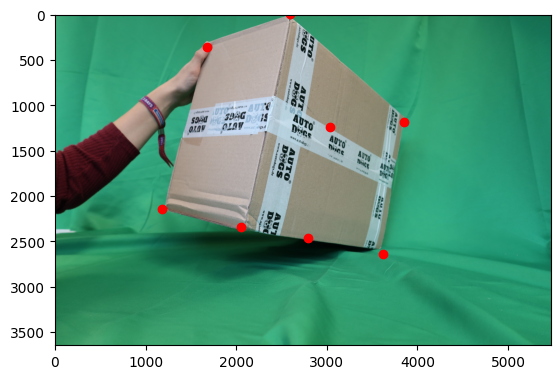

In [34]:
bbox= {'kps': points, "obj_scale": correct_dim}
meta={"width": img.shape[1],"height": img.shape[0], "camera_matrix":camera_ford }
projected_points, point_3d_cam, scale, points_ori, bbox=pnp_shell(opt, meta, bbox, points, correct_dim, OPENCV_RETURN=False)
for p in bbox["projected_cuboid"]:
    plt.plot(p[0], p[1], 'ro')
plt.imshow(img)
plt.show()


In [35]:
print(bbox)

{'kps': [[1175, 2145], [2061, 2328], [1663, 342], [2596, 19], [2786, 2481], [3619, 2654], [3037, 1227], [3863, 1175]], 'obj_scale': (395, 300, 208), 'location': [-0.13838556519482778, -0.007090665791722066, -2.1708010014689694], 'quaternion_xyzw': Quaternion([-0.31471569,  0.27050513,  0.54841405,  0.72596353]), 'projected_cuboid': array([[1181.60337844, 2147.34986909],
       [2052.43584384, 2341.36383896],
       [1673.5378772 ,  351.65919009],
       [2599.02299521,   -5.27298292],
       [2792.6800085 , 2467.24078033],
       [3615.04940053, 2642.90363494],
       [3036.25227068, 1242.89856934],
       [3850.22440917, 1185.5879702 ]]), 'kps_3d_cam': array([[-0.13838557, -0.00709067, -2.170801  ],
       [ 0.16239528, -0.78066115, -1.83212692],
       [ 0.19537348, -0.25813614, -1.37760391],
       [-0.80412632, -0.58026902, -1.99237351],
       [-0.77114813, -0.05774401, -1.53785051],
       [ 0.494377  ,  0.04356268, -2.8037515 ],
       [ 0.52735519,  0.56608769, -2.34922849],
  